In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.point import Point
from shapely.ops import cascaded_union

import pandas as pd
import numpy as np
import os
import sys

In [10]:
#importando shapes
# amazonia = gpd.GeoDataFrame.from_file('./original_data/amazonia_legal.shp')
# cidades_estado = gpd.GeoDataFrame.from_file('./original_data/para.shp')
# desmatamento = gpd.GeoDataFrame.from_file('./original_data/desmatamento_112017.shp')

In [70]:
#importando shapes
amazonia = gpd.GeoDataFrame.from_file('./original_data/amazonia_legal.shp')
cidades_estado = gpd.GeoDataFrame.from_file('./original_data/para.shp')
desmatamento = gpd.GeoDataFrame.from_file('./original_data/Deter_201706.shp')

In [71]:
#definindo listas auxiliares com as informações
colunas_estado = list(cidades_estado.columns) # Colunas do dataframe estado
nomes_cidades = list(cidades_estado.NM_MUNICIP) # nomes das cidades
nomes_cidades = [cidade.replace("'", "") for cidade in nomes_cidades] # nomes das cidades

/home/adriano/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


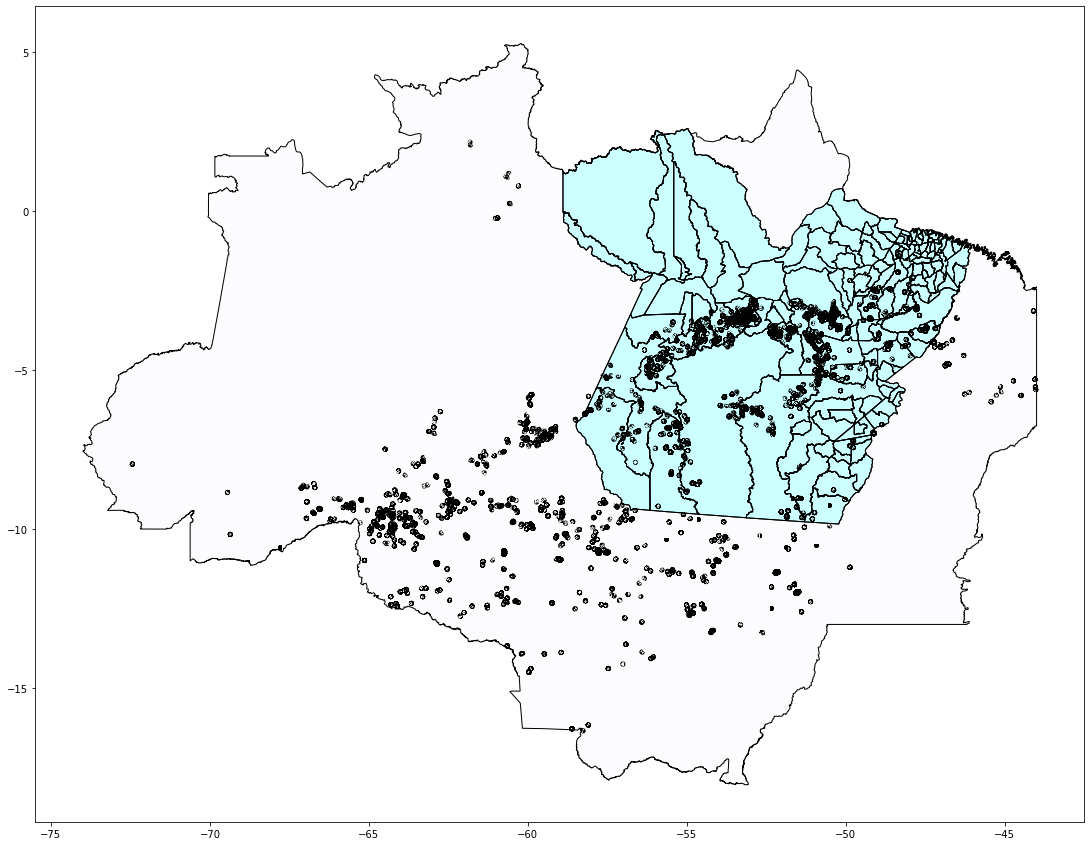

In [72]:
#Exibindo mapa completo
fig, ax = plt.subplots(figsize = (25,15)) 

amazonia.plot(cmap = 'Purples',ax=ax, legend=True)
amazonia.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax)

cidades_estado.plot(ax=ax, color='#CCFFFF', edgecolor='black')
cidades_estado.geometry.boundary.plot(color='black',edgecolor='k',linewidth = 1,ax=ax)

desmatamento.plot(cmap = 'Reds', ax=ax)
desmatamento.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 5,ax=ax)
plt.savefig('./amazonia.png', format='png', dpi=300)
fig.show()

In [67]:
#salvar centroids desmatamento
centroids = [np.dstack(d.centroid.coords.xy).tolist() for d in desmatamento.geometry]
centroids = [c[0][0] for c in centroids]
centroids = [list(map(float, (y, x))) for x, y in centroids]
line = ''
c = 1
for x in range(len(centroids)):
    line += (str(centroids[x][0])+' '+str(centroids[x][1]))+'\n'

with open('201710.txt', 'a') as f:
    f.write(line)

In [9]:
# Caso o municipio tenha multipoligonos, aplica o convex hull para que se treansforme em poligono
def convexHull(multipolygon):
    return cascaded_union([m for m in polygon]).convex_hull

# Pega a o Geo Pandas Serie de uma dada cidade
def getLineCity(name):
    name = name.upper()
    query = "%s == '%s'"%(colunas_estado[0], name)
    return cidades_estado.query(query)

def getPointsPolygonCity(city):
    try:
        points = getLineCity(city)
        coords = None

        if type(list(points.geometry)[0]) == MultiPolygon:
            points = convexHull(list(points.geometry)[0])
            coords = points.boundary.coords.xy
        else:
            coords = list(points['geometry'])[0].boundary.coords.xy

        line = ''
        for x in range(len(coords[0])):
            line += ' '+str(coords[1][x])+' '+str(coords[0][x])

        return line
    except IndexError:
        print('Error: ', city)

def writePoints(city):
    points = getPoints(city)
    try:
        with open('./polygons/'+(city.lower())+'.txt', 'a') as f:
            f.write(points)
    except TypeError:
        print('Error to write ', city)